# Problem Set 7
## Sihan Zha

## Problem 1

In [96]:
import numpy as np
import pandas as pd
import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold
from sklearn import metrics 
from sklearn.metrics import classification_report, mean_squared_error
from pylab import rcParams
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib.ticker import MultipleLocator
from scipy.interpolate import LSQUnivariateSpline

In [130]:
wine = pd.read_csv("data/strongdrink.txt")
wine.head()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [131]:
#1 (a)
X = wine[["alco","malic","tot_phen","color_int"]]
y = wine["cultivar"]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.25,random_state=20)

clf = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(X_train, y_train)

print("When j=1, the intercept is", clf.intercept_[0], ", the coefficients are", clf.coef_[0])
print("When j=2, the intercept is", clf.intercept_[1], ", the coefficients are", clf.coef_[1])

When j=1, the intercept is -24.02761652694668 , the coefficients are [ 1.70173443 -0.26578756  1.22410094  0.02250699]
When j=2, the intercept is 22.78073250150875 , the coefficients are [-1.46629729 -0.33295144  0.66355615 -0.92268168]


In [132]:
y_pred=clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.87      1.00      0.93        13
           2       1.00      0.90      0.95        21
           3       1.00      1.00      1.00        10

   micro avg       0.95      0.95      0.95        44
   macro avg       0.96      0.97      0.96        44
weighted avg       0.96      0.95      0.96        44



The error rates for group 1, 2, and 3 are 13%, 0%, and 0%, respectively.  
The model is best at predicting the third cultivar since it has the highest f1-score.  
The one with the most observations are cultivar 2, not cultivar 3.

In [133]:
MSE_vs = ((y_test - y_pred) ** 2).sum() / y_pred.shape[0]
print('Validation set MSE = ', MSE_vs)

Validation set MSE =  0.045454545454545456


In [134]:
#1 (b)
Xvals = wine[["alco","malic","tot_phen","color_int"]].values
yvals = wine["cultivar"]

N_loo = Xvals.shape[0]
loo = LeaveOneOut()
loo.get_n_splits(Xvals)
MSE_vec = np.zeros(N_loo)

y_testr = np.zeros(X.shape[0])
y_predr = np.zeros(X.shape[0])

for train_index, test_index in loo.split(Xvals):
    X_train, X_test = Xvals[train_index], Xvals[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    Logreg = LogisticRegression(random_state = 20, solver='newton-cg',
                                multi_class='multinomial').fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    y_predr[test_index] = y_pred
    y_testr[test_index] = y_test
    if y_test.item() == y_pred:
        MSE_vec[test_index] = 0
    else:
        MSE_vec[test_index] = 1
        



    
MSE_loo = MSE_vec.mean()
MSE_loo_std = MSE_vec.std()
print('test estimate MSE loocv=', MSE_loo,
      ', test estimate MSE standard err=', MSE_loo_std)

test estimate MSE loocv= 0.13636363636363635 , test estimate MSE standard err= 0.3431742925123068


In [135]:
print(classification_report(y_testr, y_predr))

              precision    recall  f1-score   support

         1.0       0.81      0.81      0.81        59
         2.0       0.84      0.86      0.85        71
         3.0       0.98      0.93      0.96        46

   micro avg       0.86      0.86      0.86       176
   macro avg       0.88      0.87      0.87       176
weighted avg       0.87      0.86      0.86       176



In [138]:
k = 4
kf = KFold(n_splits=k, random_state=10, shuffle=True)
kf.get_n_splits(Xvals)

MSE_vec_kf = np.zeros(k)
error = 0
k_ind = int(0)
for train_index, test_index in kf.split(Xvals):
    print('k index=', k_ind)
    X_train, X_test = Xvals[train_index], Xvals[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    LogReg = LogisticRegression()
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    
    error += (y_test!=y_pred).mean()
    MSE_vec_kf[k_ind] = (y_test != y_pred).mean()
    print('MSE for test set', k_ind, ' is', MSE_vec_kf[k_ind])
    y_predr[test_index] = y_pred
    y_testr[test_index] = y_test
    k_ind += 1

error_rate = error/k_ind
MSE_kf = MSE_vec_kf.mean()
MSE_kf_std = MSE_vec_kf.std()
print('test estimate MSE k-fold=', MSE_kf,
      'test estimate error rate=', error_rate)
print(classification_report(y_testr, y_predr))
print('The error rate is higher than previous results.')

k index= 0
MSE for test set 0  is 0.22727272727272727
k index= 1
MSE for test set 1  is 0.22727272727272727
k index= 2
MSE for test set 2  is 0.13636363636363635
k index= 3
MSE for test set 3  is 0.09090909090909091
test estimate MSE k-fold= 0.17045454545454544 test estimate error rate= 0.17045454545454544
              precision    recall  f1-score   support

         1.0       0.78      0.73      0.75        59
         2.0       0.79      0.85      0.82        71
         3.0       0.96      0.93      0.95        46

   micro avg       0.83      0.83      0.83       176
   macro avg       0.84      0.84      0.84       176
weighted avg       0.83      0.83      0.83       176

The error rate is higher than previous results.


D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

## Problem 2

In [50]:
cool = pd.read_csv("data/CoolIndex.txt",names=["Age","Cool Index"])

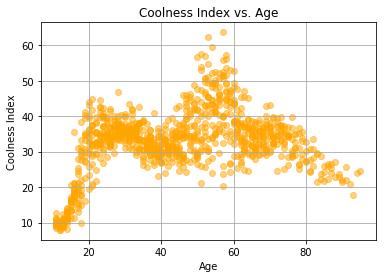

In [81]:
#2 (a)

fig, ax = plt.subplots()
plt.scatter(cool['Age'], cool['Cool Index'], c='orange', marker='o',
            label='Data', alpha = 0.5)

plt.xlabel("Age")
plt.ylabel("Coolness Index")
plt.title("Coolness Index vs. Age")

plt.grid(b=True, which='major', color='0.65', linestyle='-')

In [85]:
cool['range_1'] = 0
cool['range_2'] = 0
cool['range_3'] = 0
cool['range_4'] = 0
cool['range_5'] = 0


for i in range(len(cool['Age'])):
    if cool['Age'].loc[i] >= 11 and cool['Age'].loc[i] < 22:
        cool['range_1'].loc[i] = 1
    elif cool['Age'].loc[i] >= 22 and cool['Age'].loc[i] < 40:
        cool['range_2'].loc[i] = 1
    elif cool['Age'].loc[i] >= 40 and cool['Age'].loc[i] < 59:
        cool['range_3'].loc[i] = 1
    elif cool['Age'].loc[i] >= 59 and cool['Age'].loc[i] < 77:
        cool['range_4'].loc[i] = 1
    elif cool['Age'].loc[i] >= 77 and cool['Age'].loc[i] <= 95:
        cool['range_5'].loc[i] = 1


D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [86]:
X=cool[["range_1","range_2","range_3","range_4","range_5"]]
reg=sm.OLS(cool['Cool Index'],X).fit()
print(reg.summary())


                            OLS Regression Results                            
Dep. Variable:             Cool Index   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     178.7
Date:                Wed, 27 Feb 2019   Prob (F-statistic):          3.73e-114
Time:                        03:32:52   Log-Likelihood:                -3214.5
No. Observations:                 956   AIC:                             6439.
Df Residuals:                     951   BIC:                             6463.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
range_1       20.1025      0.562     35.746      0.0

In [87]:
reg.predict([0,0,0,1,0])

array([35.22540004])

The estimated step function values for each range is 10.1025, 34.4758, 37.6351, 35.2254, 27.2964, respectively.

The predicted coolness of a 73-year old is 35.2254.

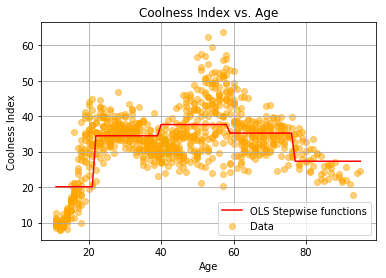

In [92]:
fig, ax = plt.subplots()
plt.scatter(cool['Age'], cool['Cool Index'], c='orange', marker='o',
            label='Data', alpha = 0.5)
plt.plot(cool.Age, reg.predict(), "r", label = "OLS Stepwise functions")
plt.xlabel("Age")
plt.ylabel("Coolness Index")
plt.title("Coolness Index vs. Age")
plt.legend()
plt.grid(b=True, which='major', color='0.65', linestyle='-')

In [103]:
cool2 = cool.groupby('Age').mean()
cool2.reset_index(level=0, inplace=True)
cool2.head()

,Age,Cool Index,range_1,range_2,range_3,range_4,range_5
0,11.0,10.110237,1,0,0,0,0
1,12.0,9.365623,1,0,0,0,0
2,13.0,10.015882,1,0,0,0,0
3,14.0,11.747109,1,0,0,0,0
4,15.0,15.434739,1,0,0,0,0


In [107]:
knots = [22,40,59,77]
LS=LSQUnivariateSpline(np.array(cool2['Age']), 
                       cool2['Cool Index'], t=knots, k=1)

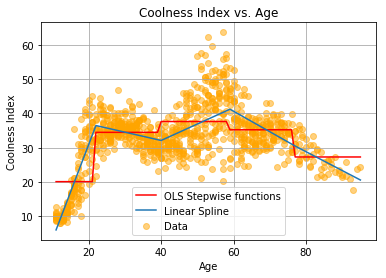

In [109]:
fig, ax = plt.subplots()
plt.scatter(cool['Age'], cool['Cool Index'], c='orange', marker='o',
            label='Data', alpha = 0.5)
plt.plot(cool.Age, reg.predict(), "r", label = "OLS Stepwise functions")
plt.plot(cool2.Age, LS(cool2.Age), label = "Linear Spline")

plt.xlabel("Age")
plt.ylabel("Coolness Index")
plt.title("Coolness Index vs. Age")
plt.legend()
plt.grid(b=True, which='major', color='0.65', linestyle='-')

In [111]:
CS=LSQUnivariateSpline(np.array(cool2['Age']), 
                       cool2['Cool Index'], t=knots, k=3)

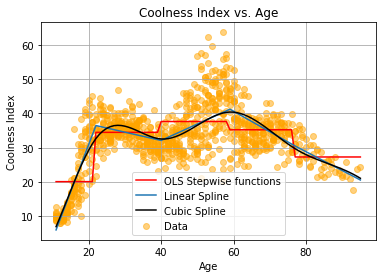

In [117]:
fig, ax = plt.subplots()
plt.scatter(cool['Age'], cool['Cool Index'], c='orange', marker='o',
            label='Data', alpha = 0.5)
plt.plot(cool.Age, reg.predict(), "r", label = "OLS Stepwise functions")
plt.plot(cool2.Age, LS(cool2.Age), label = "Linear Spline")
plt.plot(cool2.Age, CS(cool2.Age), "k", label = "Cubic Spline")

plt.xlabel("Age")
plt.ylabel("Coolness Index")
plt.title("Coolness Index vs. Age")
plt.legend()
plt.grid(b=True, which='major', color='0.65', linestyle='-')